In [1]:
from distributed import Nanny
from matplotlib.pyplot import contour
from networkx.algorithms.bipartite.basic import color

# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

MCP_GFP_ParB_mCh_datasets = [
    'test_data/2025-01-24/MCP-GFP_ParB-mCh_hbP2P_intB_embryo01',
    'test_data/2025-01-24/MCP-GFP_ParB-mCh_hbP2P_intB_embryo02',
    'test_data/2025-01-24/MCP-GFP_ParB-mCh_hbP2P_intB_embryo03',
    'test_data/2025-01-24/MCP-GFP_ParB-mCh_hbP2P_intB_embryo04',
    'test_data/2025-01-24/MCP-GFP_ParB-mCh_hbP2P_intB_embryo05',
    'test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo01',
    'test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo02',
    'test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo03',
    'test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo04',
    'test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo05'
]

test_dataset_name = dataset_folder + MCP_GFP_ParB_mCh_datasets[7]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/2025-01-29/MCP-GFP_ParB-mCh_hbP2P_intB_embryo03


In [2]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

root = tk.Tk()
root.withdraw();

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [3]:
mpl.use('TkAgg')
# %matplotlib widget

In [4]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [5]:
import gc
gc.disable()
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)
gc.enable()

In [6]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        # scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="10GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36425 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41353' processes=14 threads=14, memory=130.39 GiB>


In [11]:
client.restart()

AttributeError: 'NoneType' object has no attribute 'restart'

In [7]:
client.shutdown()

In [7]:
print(client.dashboard_link)

http://127.0.0.1:36425/status


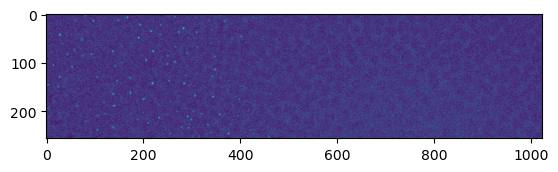

In [8]:
# Plot both channels of the movie in line

%matplotlib inline
time_frame = 3
z_slice = 6

plt.figure()
plt.imshow(dataset.channels_full_dataset[0][time_frame, z_slice, :, :])
plt.show()


In [6]:
# Set the channels for spot and nuclear tracking
# spot_channel = 0
nuclear_channel = 0

# Spot Tracking

In [9]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous


False

In [10]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot tracking results')

    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)

else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')

    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[1],
        global_metadata=dataset.export_global_metadata[1],
        frame_metadata=dataset.export_frame_metadata[1],
        labels=None,#nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )

    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name,
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )

    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Do spot tracking for the dataset


IndexError: list index out of range

In [ ]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()